In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import time
import os
import control
from scipy import signal
from numpy import array
from numpy import matmul 
from numpy.linalg import inv
from numpy import linalg as LA

In [2]:
Am=array([[0,1],[-4,0]])
Bm=np.array([[1],[0]])
Cm=np.array([[0,1]])
Dm=[[0]]
Nc=3
Np=10
dt=0.1

#Egin behar dugun lehenengo gauza jarraitutik diskretora pasatu 

sys_state_space=control.StateSpace(Am, Bm, Cm, Dm)
sys_state_discrete= control.c2d(sys_state_space,dt,'zoh')

Am=array([[0.98006658, 0.09933467],[-0.39733866, 0.98006658]])
Bm=array([[0.09933467],[-0.01993342]])
Cm=array([[0,1]])

print("Am model matrizea \n",Am)
print("Bm model matrizea \n",Bm)
print("Cm model matrizea \n",Cm)

#Orain kalkulatuko dugu zeintzuk diren sistema zabalduaren matrizeak: 
#Gogoratu behar dugu (dx=Am x+Bm u) ereduko sistema baldin bada (dx=Ae x +Be deltau) non x=(deltax,y) dugun  

if len(Cm)==1 and len(Bm)==1:
    m1=1
    n1=1
    n_in=1
else:
    [m1,n1]=len(Cm),len(Cm[0])
    [n1,n_in]=len(Bm),len(Bm[0])
    
Ae=np.identity(n1+m1)
Ae[0:n1,0:n1]=Am
Ae[n1:n1+m1,0:n1]=np.matmul(Cm,Am)
Be=np.zeros((n1+m1,n_in))
Be[0:n1,:]=Bm
Be[n1:n1+m1,:]=np.matmul(Cm,Bm)
Ce=np.zeros((m1,m1+n1))
Ce[:,n1:n1+m1]=np.eye(m1,m1)

#Orain optimizazio prozesua egingo dugu: atal honen helburua deltaU bektorea lortzea da 
#Hau da behar dugun kontrol seinalea erreferentzia lortzeko 
#deltaU lortzeko lehenengo zenbait matrize kalkulatu behar ditugu

n=n1+m1
h=np.reshape(Ce[0,:],(1,len(Ce[0,:])))
F=np.matmul(Ce,Ae)

for kk in range(1,Np):
    h=np.insert(h,kk,np.matmul(h[kk-1,:],Ae),0)
    F=np.insert(F,kk,np.matmul(F[kk-1,:],Ae),0)
v=np.matmul(h,Be)
Phi=np.zeros((Np,Nc))
Phi[:,0]=v[:,0]
for i in range(1,Nc):
    Phi[:,i]=np.concatenate([np.zeros((i,1)),np.reshape(v[0:Np-i,0],(len(v[0:Np-i,0]),1))])[:,0]
BarRs=np.ones((Np,1))
Phi_Phi=np.matmul(Phi.transpose(),Phi)
Phi_F=np.matmul(Phi.transpose(),F)
Phi_R=np.matmul(Phi.transpose(),BarRs)
print("Phi_Phi matrizea \n",Phi_Phi)
print("Phi_F matrizea \n",Phi_F)
print("Phi_R matrizea \n",Phi_R)

#deltaU hori kalkulatzeko, gure egoera bektorean hasierako baldintzak ipini behar ditugu: 
state_v=array([[0.1],[0.2],[0.3]])
deltaU=matmul(inv(Phi_Phi+0*np.identity(Phi_Phi.shape[0])),Phi_R-matmul(Phi_F,state_v))
print("DeltaU \n",deltaU)

#deltaU horrek bi atal ditu: 1) setpoint 2)state feedback u=-Kmpc x

setpoint=matmul(inv(Phi_Phi+0*np.identity(Phi_Phi.shape[0])),Phi_R)
Ky=setpoint[0] #lehenengo elementua 
state=matmul(inv(Phi_Phi+0*np.identity(Phi_Phi.shape[0])),Phi_F)
Kmpc=state[0] #lehenego ilara
print("Kmpc \n",Kmpc)

#Behin Kmpc state feedback kalkulatu dugula begizta itxiko poloak non dauden ikus dezakegu: 
print("Balio propioak begizta itxian\n",LA.eigvals(Ae-matmul(Be,np.reshape(Kmpc,(1,3)))))

Am model matrizea 
 [[ 0.98006658  0.09933467]
 [-0.39733866  0.98006658]]
Bm model matrizea 
 [[ 0.09933467]
 [-0.01993342]]
Cm model matrizea 
 [[0 1]]
Phi_Phi matrizea 
 [[6.00673617 4.88534967 3.81504996]
 [4.88534967 4.00126418 3.1474512 ]
 [3.81504996 3.1474512  2.4952391 ]]
Phi_F matrizea 
 [[ 65.52854721 -25.20993673  -6.17675151]
 [ 53.12806026 -19.67091025  -4.76060463]
 [ 41.35533745 -14.69736408  -3.53340249]]
Phi_R matrizea 
 [[-6.17675151]
 [-4.76060463]
 [-3.53340249]]
DeltaU 
 [[-14.95345752]
 [ 32.47660292]
 [-19.57318554]]
Kmpc 
 [ 17.90641504 -39.06643175 -29.96586053]
Balio propioak begizta itxian
 [-1.94644344e-01+0.00000000e+00j  3.41226059e-11+3.03173105e-06j
  3.41226059e-11-3.03173105e-06j]


Eredua soilik erabilita askotan ez da nahikoa konportamoldea aurresateko. Hauxe gertatzen da penduluaren angeluaren kasuan. 

Kasu horietan, observer erabili behar dugu --> Jakin behar dugu non ipini poloak 

Demagun esaten digutela behatzailearen nahi ditugun poloak 0.1 eta 0.2 direla.  


In [3]:
P=array([0.0001,-0.0001])
fsf2 = signal.place_poles(Am.transpose(), Cm.transpose(), P)
Kobs1=fsf2.gain_matrix
print(Kobs1)
print(fsf2.computed_poles)

[[-2.31807543  1.96013316]]
[-9.99999985e-05  9.99999997e-05]


In [4]:
#Observerraren poloen kokapena jakinda, Kobs kalkuatu dezakegu 

P=array([0,0.000001,0.00001])
fsf2 = signal.place_poles(Ae.transpose(), Ce.transpose(), P)
Kobs=fsf2.gain_matrix
print(Kobs)
print(fsf2.computed_poles)

[[-2.31801085  1.96010697  2.96010697]]
[-2.96313107e-06+0.00000000e+00j  1.45789786e-05-7.75274524e-06j
  1.45789786e-05+7.75274524e-06j]


34.60390162638214
10.0


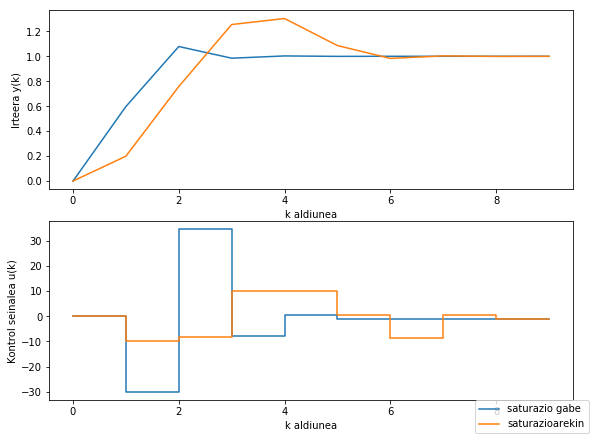

In [5]:
[n1,n_in]=len(Be),len(Be[0])
xm=[[0],[0]] #Egoera bektorea 
xf=np.zeros((n,1)) #Egoera bektorea augmented model 
Nsim=10 
r=np.ones((Nsim,1)) #Lortu nahi dugun erreferentzia, hots, unitatea 
u=0
y=0

u1=np.zeros(Nsim) #Hemen gordeko dugu iterazioetan zeharreko kontrol seinalearen balioa 
y1=np.zeros(Nsim) #Hemen gordeko dugu iterazioetan zeharreko irteera seinalearen balioa 

k=np.zeros(Nsim)
for i in range(0,Nsim):
    k[i]=i #Gure iterazioen bektorea (denboraren baliokide diskretoa)

fig, axes = plt.subplots(nrows=2, ncols=1,  figsize=(8,6), );# sharex=True, sharey=True,;
ax0, ax1 = axes.flat
fig.tight_layout()

ax0.set_xlabel('k aldiunea');
ax0.set_ylabel('Irteera y(k)');
#ax0.set_xlim(left_x_lim, right_x_lim); #x ardatza definitu
#ax0.set_ylim(left_y_lim, right_y_lim); #y ardatza definitu

ax1.set_xlabel('k aldiunea');
ax1.set_ylabel('Kontrol seinalea u(k)');
#ax1.set_xlim(left_x_lim, right_x_lim); #x ardatza d
#ax1.set_ylim(left_y_lim, right_y_lim); #y ardatza definitu

j=0
for kk in range(0,Nsim):
    u1[kk]=u
    xm_old=xm
    xm=matmul(Am,xm)+Bm*u #Orain gure ereduan sartzen dugu (zabalduan ez)
    y=matmul(Cm,xm) #Irteeeraren adierazpena 
    
    xf=np.concatenate((xm-xm_old,y),0) #xf augmented modelaren egoera bektorea 
    deltaU=matmul(inv(Phi_Phi+j*np.identity(Nc)),Phi_R*r[kk]-matmul(Phi_F,xf)) #iterazio bakoitzean kalkulatu behar dugu berriro ere 
    deltau=deltaU[0,0] #delatU kalkulatzen da (0,...,Nc-1) baina soilik lehenengo balioa inplementatzen da 
    
    u=u+deltau
    y1[kk]=y
    
print(max(u1))    
ax0.plot(k,y1)
ax1.step(k,u1,where='post',label="saturazio gabe")

#--------------------------------------------------------------------------------------------------------------------------

xm=[[0],[0]] #Egoera bektorea 
xf=np.zeros((n,1)) #Egoera bektorea augmented model 
Nsim=10
r=np.ones((Nsim,1)) #Lortu nahi dugun erreferentzia, hots, unitatea 
u=0
y=0

u1=np.zeros(Nsim) #Hemen gordeko dugu iterazioetan zeharreko kontrol seinalearen balioa 
y1=np.zeros(Nsim) #Hemen gordeko dugu iterazioetan zeharreko irteera seinalearen balioa 

k=np.zeros(Nsim)
for i in range(0,Nsim):
    k[i]=i #Gure iterazioen bektorea (denboraren baliokide diskretoa)
j=0
for kk in range(0,Nsim): 

    u1[kk]=u
    xm_old=xm
    xm=matmul(Am,xm)+Bm*u #Orain gure ereduan sartzen dugu (zabalduan ez)
    y=matmul(Cm,xm) #Irteeeraren adierazpena 
    
    xf=np.concatenate((xm-xm_old,y),0) #xf augmented modelaren egoera bektorea 
    deltaU=matmul(inv(Phi_Phi+j*np.identity(Nc)),Phi_R*r[kk]-matmul(Phi_F,xf)) #iterazio bakoitzean kalkulatu behar dugu berriro ere 
    deltau=deltaU[0,0] #delatU kalkulatzen da (0,...,Nc-1) baina soilik lehenengo balioa inplementatzen da 
    u=u+deltau
    
    if (u>10):
        u=10
        deltau=10-u1[kk-1]
    elif (u<-10):
        u=-10
        deltau=-10-u1[kk-1]

    y1[kk]=y

print(max(u1))
ax0.plot(k,y1)
plt.step(k,u1,where='post',label="saturazioarekin")



fig.legend(loc="lower right")


fig.savefig(os.path.join(os.path.expanduser("~"),"Desktop","PENDULUA","satu+satugabe.png"),format="png",dpi = 150);